In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import sys
import hardware_control.wx_programs as wx
import hardware_control.bnc as bnc
from classes.generator import *
from hardware_control.hardware_config import *
from experiment_configuration.values import *
from classes.qubit_class import *
import daq.daq_programs_homo as daq
import seaborn as sns
import standard_sequences.rabi as rabi
import analysis.plotting as plotting
import analysis.analysis as analysis
import standard_sequences.spectroscopy as spec
import standard_sequences.rabi as rabi
import standard_sequences.T1_measurements as T1
import standard_sequences.ramsey as ramsey

In [3]:
wx_addr = wx.get_wx_address()
main_directory = r"C:\Users\quantum1\Documents"
save_dir = rf"{main_directory}\Python Scripts\Important Blue Fridge Python Files\New\nonlinear_QM\data"
target_bnc_address_6 = "USB0::0x03EB::0xAFFF::411-433500000-0753::INSTR"
C1_address="GPIB0::6::INSTR"
C2_address="GPIB0::10::INSTR"
bnc.set_bnc_output(
    general_vals_dict["qubit_bnc"], power_dBm=13, bnc_addr=target_bnc_address_6
)
bnc.set_bnc_output(
    readout_dict["RO_LO"],
    power_dBm=readout_dict["RO_LO_pwr"],
    bnc_addr=bnc_address["target_bnc_black"],
)


In [4]:
q1 = Qubit(q1_dict, readout_dict)
q2 = Qubit(q2_dict, readout_dict)
readout = Readout(readout_dict)
print(f"{q1}\n{q2}")
# bnc.set_DC_output(bnc_addr=C2_address, voltage=0.01)

Qubit(ro_amp=0.5, ef_half_amp=1.3, ge_time=77, ge_amp=1, RO_IF=None, RO_LO=6.6247, qubit_thr=[-10000, -600], ef_ssm=-0.25684, qubit_id=q1, RO_LO_pwr=16, ef_amp=1.5, ro_dur=3000, ge_ssm=-0.117, ef_time=44, IQ_angle=60, ef_half_time=25, RO_LO_45=6.3804, mixer_offset_ef=6, ROIF=0.1026600000000002, mixer_offset_ge=2.5, RO_LO_34=6.4804, ro_freq=6.72736)
Qubit(ro_amp=0.45, ef_half_amp=None, ge_time=62, ge_amp=1, RO_IF=None, RO_LO=6.6247, qubit_thr=[-10000, 1900], ef_ssm=-0.2962, qubit_id=q2, RO_LO_pwr=16, ef_amp=1, ro_dur=3000, ge_ssm=-0.155, ef_time=None, IQ_angle=25, ef_half_time=None, RO_LO_45=6.3804, mixer_offset_ef=None, ROIF=0.030739999999999768, mixer_offset_ge=2.5, RO_LO_34=6.4804, ro_freq=6.65544)


In [5]:
def spectroscopy(q1,
                 q2,
                 general_vals_dict,
                 f1:float,
                 f2:float,
                 spec_amp:float,
                 num_steps:int,
                 sweep_time:float,
                 reps:int
                 ):
    spec.spectroscopy_ge(
        q1,
        q2,
        general_vals_dict,
        ssm_start=f1,
        ssm_stop=f2,
        spec_amp=spec_amp,
        sweep_time=sweep_time,
        verbose=False,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=False
    )
    return values

def spectroscopy_sweep(q1,
                q2,
                general_vals_dict,
                f1: float,
                f2: float,
                spec_amp: float,
                num_steps: int,
                sweep_time: float,
                reps: int,
                address: str,
                start_voltage: float,
                stop_voltage: float,
                num_points: int,
            ):
   
    sweep_vals = np.linspace(start_voltage, stop_voltage, num_points)
    I1 = np.zeros((num_points, num_steps))
    Q1 = np.zeros((num_points, num_steps))
    I2 = np.zeros((num_points, num_steps))
    Q2 = np.zeros((num_points, num_steps))

    # Run the spectroscopy sweep setup
    spec.spectroscopy_ge(
        q1,
        q2,
        general_vals_dict,
        ssm_start=f1,
        ssm_stop=f2,
        spec_amp=spec_amp,
        sweep_time=sweep_time,
        verbose=False,
    )
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"],
        offset=general_vals_dict["wx_offs"]
    )
    _ = daq.run_daq_het_2q(
            q1,
            q2,
            num_patterns=num_steps,
            num_records_per_pattern=reps,
            verbose=False
        )
    # Main voltage sweep
    for i, voltage in enumerate(sweep_vals):
        bnc.set_DC_output(bnc_addr=address, voltage=voltage)
        # Acquire the raw IQ data
        values = daq.run_daq_het_2q(
            q1,
            q2,
            num_patterns=num_steps,
            num_records_per_pattern=reps,
            verbose=False
        )
        I1[i] = values.rec_avg_vs_pats_1[0]
        Q1[i] = values.rec_avg_vs_pats_1[1]
        I2[i] = values.rec_avg_vs_pats_2[0]
        Q2[i] = values.rec_avg_vs_pats_2[1]

    return I1, Q1, I2, Q2
def run_rabi(
    q1,
    q2,
    general_vals_dict,
    num_steps: int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    # Run the experiment
    rabi.rabi_ge(q1, q2, general_vals_dict, num_steps, sweep_time)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

def run_T1(
    q1,
    q2,
    general_vals_dict,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
    num_steps=101
    # Run the experiment
    #(qubit1: object, qubit2: object, gen_vals: dict, sweep_time=100000, verbose=True)
    T1.T1(q1, q2, general_vals_dict, sweep_time, verbose=False)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

def run_ramsey(
    q1,
    q2,
    general_vals_dict,
    num_steps:int,
    sweep_time: float,
    reps: int,
):
    """
    Runs a single instance of the geRabi experiment
    and processes the resulting IQ data to compute probabilities vs. time.

    Returns:
        df_prob (pd.DataFrame): A DataFrame whose index is the time (computed as
                                np.linspace(0, sweep_time/1000, num_steps)) and which has
                                columns ['P_f', 'P_e', 'P_g'] corresponding to the probabilities
                                of the f, e, and g states respectively.
    """
   
    # Run the experiment
    
    ramsey.ramsey(q1, q2, general_vals_dict,num_steps, sweep_time,verbose=False)
    wx.wx_set_and_amplitude_and_offset(
        amp=general_vals_dict["wx_amps"], offset=general_vals_dict["wx_offs"]
    )
    # Acquire the raw IQ data
    values = daq.run_daq_het_2q(
        q1, q2, num_patterns=num_steps, num_records_per_pattern=reps, verbose=True
    )

    # Retrieve raw IQ data from the acquired values
    I1_raw = values.rec_readout_1[0]
    Q1_raw = values.rec_readout_1[1]
    I2_raw = values.rec_readout_2[0]
    Q2_raw = values.rec_readout_2[1]

    # Build a DataFrame from the IQ data for classification
    IQ_df = pd.DataFrame({"I1": I1_raw, "Q1": Q1_raw, "I2": I2_raw, "Q2": Q2_raw})
    return values, IQ_df

In [31]:
f1=-0.10
f2=-0.20
num_steps=101
reps=1000
spec_amp=0.05
sweep_time=10000
freq_list = np.linspace(f1, f2, num_steps)
values=spectroscopy(q2,q1,general_vals_dict,f1,f2,spec_amp,num_steps,sweep_time,reps)
dat = plotting.get_IQ_averages(values)


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 10.845940 sec
Captured 33 buffers (3.042613 buffers per sec)
Captured 101376 records (9346.908004 records per sec)
Transferred 1660944384 bytes (153139740.742395 bytes per sec)


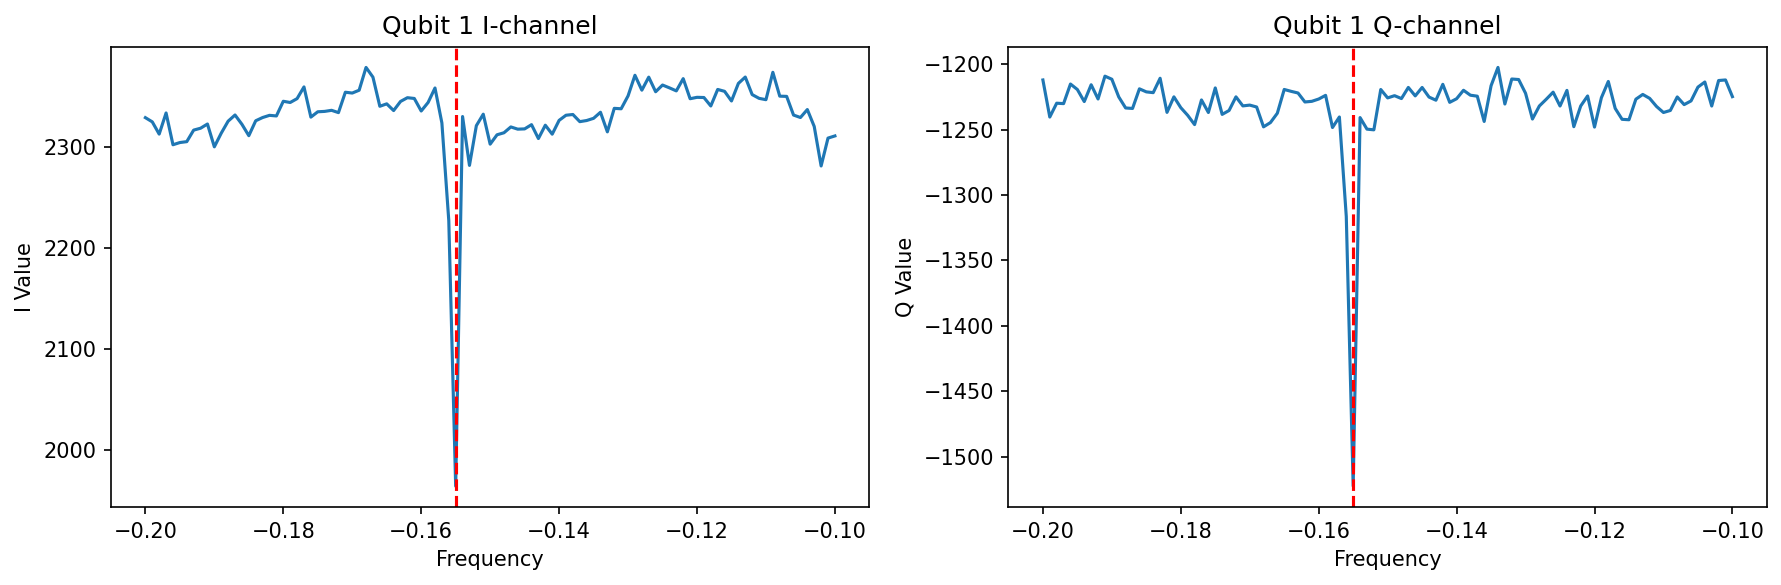

-0.155


In [32]:
freq = freq_list[np.argmin(dat["I1"])]
plotting.spectroscopy_plot(freq_list, values, [freq, freq], qubit_num=1)
print(freq)

In [22]:
f1=-0.10
f2=-0.20
num_steps=101
reps=1000
spec_amp=0.05
sweep_time=10000
voltage_start=.5
voltage_stop=-.5#resistor is 300 ohm
voltage_steps = 51
I1,Q1,I2,Q2=spectroscopy_sweep(q2,q1,general_vals_dict,f1,f2,spec_amp,num_steps,sweep_time,reps,C2_address,voltage_start,voltage_stop,voltage_steps)


writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 10.877316 sec
Captured 33 buffers (3.033837 buffers per sec)
Captured 101376 records (9319.945800 records per sec)
Transferred 1660944384 bytes (152697991.993751 bytes per sec)
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 10.801013 sec
Captured 33 buffers (3.055269 buffers per sec)
Capture

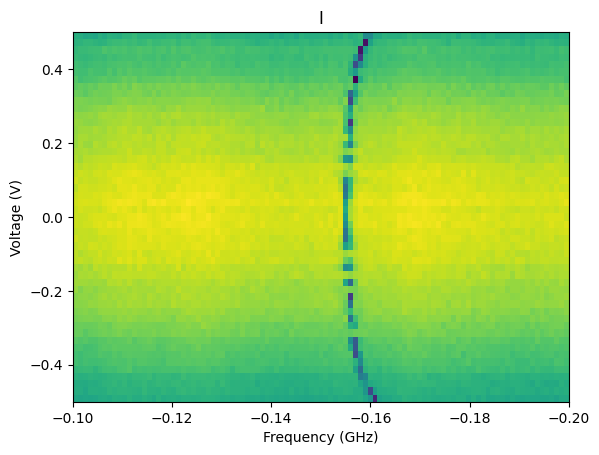

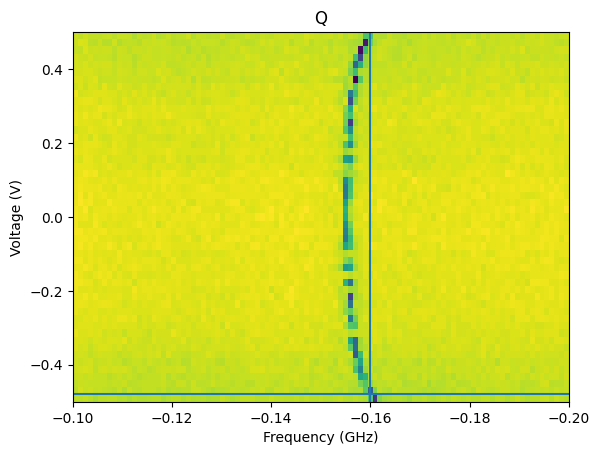

In [28]:
plt.imshow(I1, extent=[f1,f2,voltage_stop,voltage_start],aspect='auto' )
plt.ylabel('Voltage (V)')
plt.xlabel('Frequency (GHz)')
plt.title('I')
plt.show()
plt.imshow(Q1, extent=[f1,f2,voltage_stop,voltage_start],aspect='auto' )
plt.axvline(-0.16)
plt.axhline(-0.48)
plt.ylabel('Voltage (V)')
plt.xlabel('Frequency (GHz)')
plt.title('Q')
plt.show()

In [6]:
num_steps = 101
reps = 2000
sweep_time = 500
values, IQ_df = run_rabi(q2,q1,general_vals_dict,num_steps, sweep_time, reps)
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
if Qrange > Irange:
    print("Q")
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, Q, guess_vals=[11, 0.3, np.abs(np.max(Q) - np.min(Q)), 38, Q[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))
else:
    print("I")
    times = np.linspace(0, sweep_time / 1000, num_steps)
    pi_ge_fit_vals, _, _, _ = analysis.fit_sine_decay(
        times, I, guess_vals=[11, 0.3, np.abs(np.max(I) - np.min(I)), 38, I[0]]
    )
    pi_ge = abs((1 / 2 / pi_ge_fit_vals[0]) * 1000)
    print("\u03C0_ge time = {} ns".format(pi_ge))

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4


KeyboardInterrupt: 

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 1000
Buffers per acquistion: 33
DAQ samples per pattern: 8192
0, No error
Capturing 33 buffers. Press <enter> to abort
Capture completed in 20.899687 sec
Captured 33 buffers (1.578971 buffers per sec)
Captured 101376 records (4850.599057 records per sec)
Transferred 1660944384 bytes (79472214.956175 bytes per sec)


<Figure size 800x800 with 0 Axes>

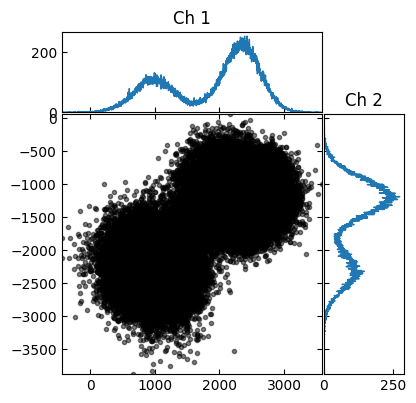

<Figure size 800x800 with 0 Axes>

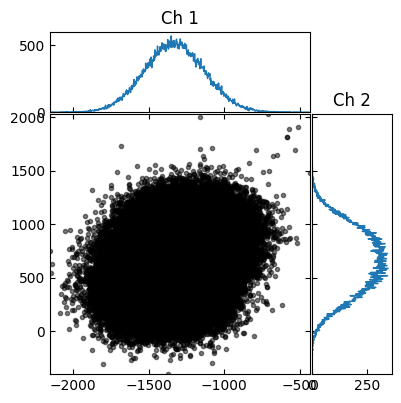

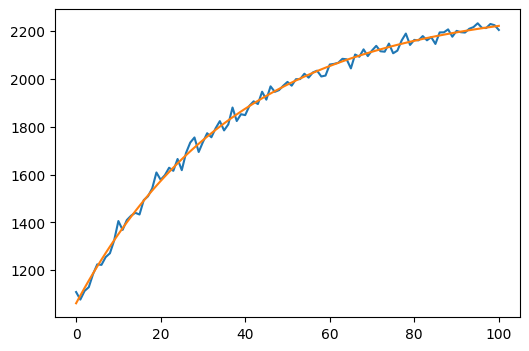



   amp: -1251.8288562904058
 gamma: 0.026297448317203435
offset: 2312.754741100315
[-1.25182886e+03  2.62974483e-02  2.31275474e+03]
T1_ge = 38.02650310166457 μs


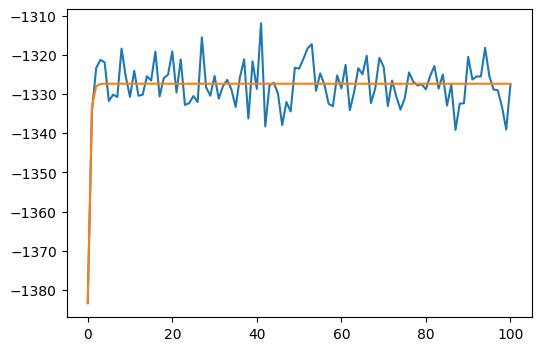



   amp: -55.99629222942329
 gamma: 2.274457397277766
offset: -1327.3780887372693
[  -55.99629223     2.2744574  -1327.37808874]
T1_ge = 0.4396653026769689 μs


In [8]:
reps = 1000
sweep_time = 100000
values, IQ_df = run_T1(q2,q1,general_vals_dict, sweep_time, reps)
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
times = np.linspace(0, sweep_time / 1000, len(Q))
if Qrange>Irange:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,Q,guess_vals=[-Qrange,0.5,Q[100]])
else:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,I,guess_vals=[-Irange,0.5,I[100]])

print(T1_ge_fit_vals)
T1_ge = 1/T1_ge_fit_vals[1]
print("T1_ge = {} \u03BCs".format(T1_ge))
Q = IQ_df["Q2"]
I = IQ_df["I2"]
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
times = np.linspace(0, sweep_time / 1000, len(Q))
if Qrange>Irange:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,Q,guess_vals=[-Qrange,0.5,Q[100]])
else:
        T1_ge_fit_vals,error_vals,T1_fit_data,_ = analysis.fit_exp_decay(times,I,guess_vals=[-Irange,0.5,I[100]])

print(T1_ge_fit_vals)
T1_ge = 1/T1_ge_fit_vals[1]
print("T1_ge = {} \u03BCs".format(T1_ge))

writing to C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
writing ch1
writing ch2
writing ch3
writing ch4
loading C:\arbsequences\strong_dispersive_withPython\test_pulse_ringupdown_bin\
num_steps 101
loading ch1
loading ch2
loading ch3
loading ch4
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
0, No error
10.225.208.207
0, No error
10.225.208.207
0, No error
Patterns: 101
Records per pattern: 2000
Buffers per acquistion: 66
DAQ samples per pattern: 8192
0, No error
Capturing 66 buffers. Press <enter> to abort
Capture completed in 20.859101 sec
Captured 66 buffers (3.164086 buffers per sec)
Captured 202752 records (9720.073720 records per sec)
Transferred 3321888768 bytes (159253687.822604 bytes per sec)


<Figure size 800x800 with 0 Axes>

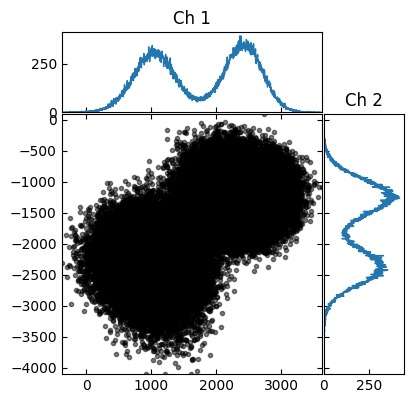

<Figure size 800x800 with 0 Axes>

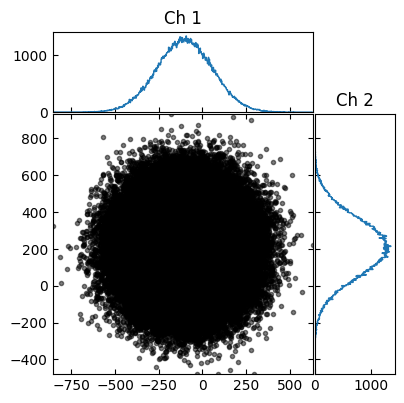

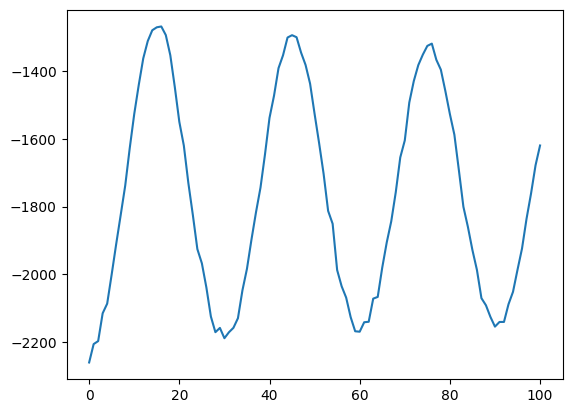

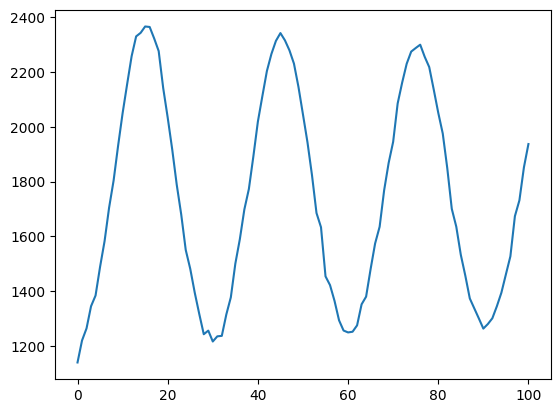

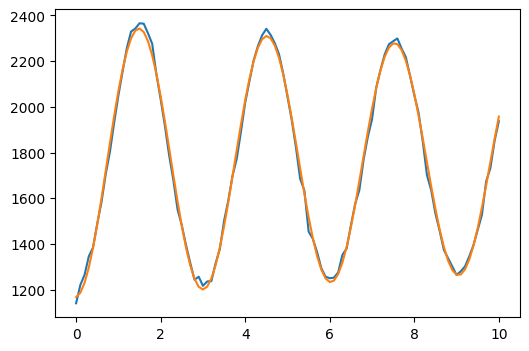



  freq: 0.3308029804369377 +/- 0.00031841835468292935
 gamma: 0.019408500680901965 +/- 0.002089833016188267
   amp: 596.7074773669408 +/- 6.688157826443885
 phase: 2792.3311408181858 +/- 0.6469694602908989
offset: 1763.5188174842178 +/- 2.2860335335931534
pi_pulse time: 1.5114736854534387 +/- 0.00031841835468292935
T2* = 51.523815076761885 μs


In [9]:
reps = 2000
sweep_time = 10000
num_steps = 101
values, IQ_df= run_ramsey(q2,q1,general_vals_dict,num_steps, sweep_time, reps)
IQ_df = plotting.get_IQ_averages(values)
Q = IQ_df["Q1"]
I = IQ_df["I1"]
plt.plot(Q)
plt.show()
plt.plot(I)
Qrange = abs(np.max(Q) - np.min(Q))
Irange = abs(np.max(I) - np.min(I))
times = np.linspace(0, sweep_time / 1000, len(Q))
if Qrange>Irange:
        T2_fit_vals,_,_,_ = analysis.fit_sine_decay(times,Q,guess_vals=[0 ,0.04600696770461763,-67.76128980276253,-263.4006117568909,0])
if Irange>Qrange:
        T2_fit_vals,_,_,_ = analysis.fit_sine_decay(times,I,guess_vals=[0 ,0.04600696770461763,-67.76128980276253,-263.4006117568909,0])
T2 = 1/T2_fit_vals[1]
print("T2* = {} \u03BCs".format(T2))